In [1]:
# Import All Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# BERT
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, Dense, Dropout, LayerNormalization,
    GlobalAveragePooling1D, MultiHeadAttention, Add)
from tensorflow.keras.models import Model

# To handle warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#  Load Dataset
df = pd.read_csv("data_to_be_cleansed.csv")

### Basic Insights from Data

In [4]:
# To show top 5 rows
df.head()

,Unnamed: 0,text,title,target
0,0,Welcome to /r/depression's check-in post - a p...,"Regular check-in post, with information about ...",1
1,1,We understand that most people who reply immed...,Our most-broken and least-understood rules is ...,1
2,2,Anyone else just miss physical touch? I crave ...,"I haven’t been touched, or even hugged, in so ...",1
3,3,I’m just so ashamed. Everyone and everything f...,Being Depressed is Embarrassing,1
4,4,I really need a friend. I don't even have a si...,I'm desperate for a friend and to feel loved b...,1


In [5]:
# Map numerical target to descriptive labels
label_map = {0: 'Stress', 1: 'Depression', 2: 'Bipolar disorder', 3: 'Personality disorder', 4: 'Anxiety'}
df['target_label'] = df['target'].map(label_map)

In [6]:
print("Shape of data:", df.shape)

Shape of data: (5957, 5)


In [7]:
print("Columns:", df.columns)

Columns: Index(['Unnamed: 0', 'text', 'title', 'target', 'target_label'], dtype='object')


In [8]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Unnamed: 0        0
text            350
title             0
target            0
target_label      0
dtype: int64


In [9]:
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


In [10]:
# Processing
df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(subset=['text'])
df['text'] = df['text'].astype(str)

In [11]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

### Exploratory Data Analysis (EDA)

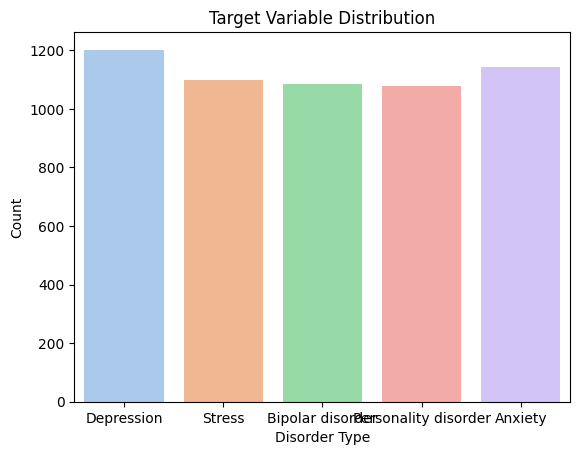

In [13]:
# (1) Target variable distribution
label_map = {0: 'Stress', 1: 'Depression', 2: 'Bipolar disorder', 3: 'Personality disorder', 4: 'Anxiety'}
df['target_label'] = df['target'].map(label_map)
sns.countplot(x='target_label', data=df, palette='pastel')
plt.title("Target Variable Distribution")
plt.xlabel("Disorder Type")
plt.ylabel("Count")
plt.show()

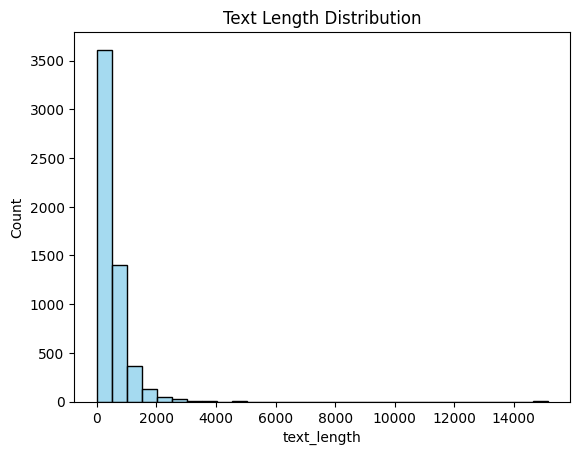

In [14]:
# (2) Text length distribution
df['text_length'] = df['clean_text'].apply(len)
sns.histplot(df['text_length'], bins=30, color='skyblue')
plt.title("Text Length Distribution")
plt.show()

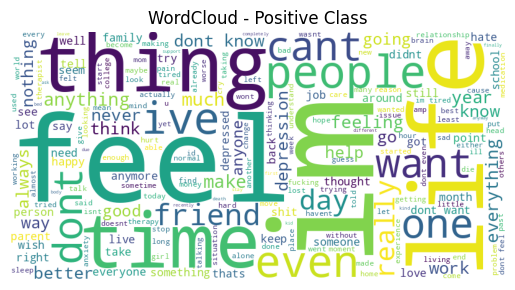

In [15]:
# (3) Word cloud of positive class
from wordcloud import WordCloud
text_positive = " ".join(df[df['target'] == 1]['clean_text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(text_positive)
plt.imshow(wc)
plt.axis("off")
plt.title("WordCloud - Positive Class")
plt.show()

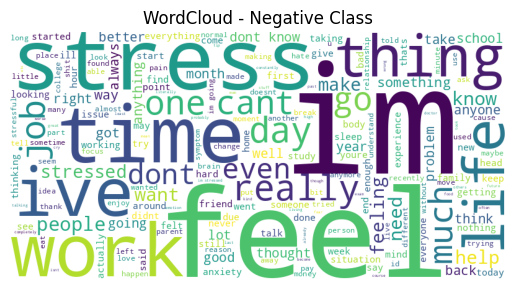

In [16]:
# (4) Word cloud of negative class
text_negative = " ".join(df[df['target'] == 0]['clean_text'])
wc2 = WordCloud(width=800, height=400, background_color='white').generate(text_negative)
plt.imshow(wc2)
plt.axis("off")
plt.title("WordCloud - Negative Class")
plt.show()

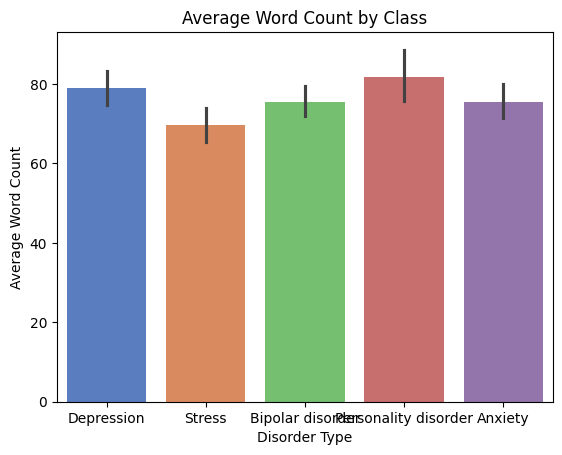

In [17]:
# (5) Average word count by target
label_map = {0: 'Stress', 1: 'Depression', 2: 'Bipolar disorder', 3: 'Personality disorder', 4: 'Anxiety'}
df['target_label'] = df['target'].map(label_map)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.barplot(x='target_label', y='word_count', data=df, palette='muted')
plt.title("Average Word Count by Class")
plt.xlabel("Disorder Type")
plt.ylabel("Average Word Count")
plt.show()

### Feature Engineering

In [18]:
# Data Preprocessing and Feature Engineering
X = df['clean_text']
y = df['target']

In [19]:
# TF-IDF Vectorization for ML models
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

In [20]:
# Split for ML models
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['target'], test_size=0.2, random_state=42)

In [21]:
# Tokenization for Neural/Transformer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100)
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X_pad, y, test_size=0.2, random_state=42)

##  Model Building and Evaluation

### AdaBoost

In [22]:
# Model 1: AdaBoost
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.8, random_state=42)

In [23]:
# Model Training
adaboost.fit(X_train_tfidf, y_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=42)

In [24]:
# Model Testing
y_pred_ada = adaboost.predict(X_test_tfidf)

In [25]:
# Model Evaluation
print(" AdaBoost Evaluation ")
print("Accuracy:", accuracy_score(y_test, y_pred_ada))
print("Precision:", precision_score(y_test, y_pred_ada, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_ada, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_ada, average='weighted'))
print(classification_report(y_test, y_pred_ada))

 AdaBoost Evaluation 
Accuracy: 0.6292335115864528
Precision: 0.6964439759692127
Recall: 0.6292335115864528
F1 Score: 0.6401795432598403
              precision    recall  f1-score   support

           0       0.81      0.59      0.69       217
           1       0.43      0.77      0.55       266
           2       0.89      0.57      0.70       191
           3       0.69      0.56      0.62       222
           4       0.74      0.62      0.67       226

    accuracy                           0.63      1122
   macro avg       0.71      0.62      0.65      1122
weighted avg       0.70      0.63      0.64      1122



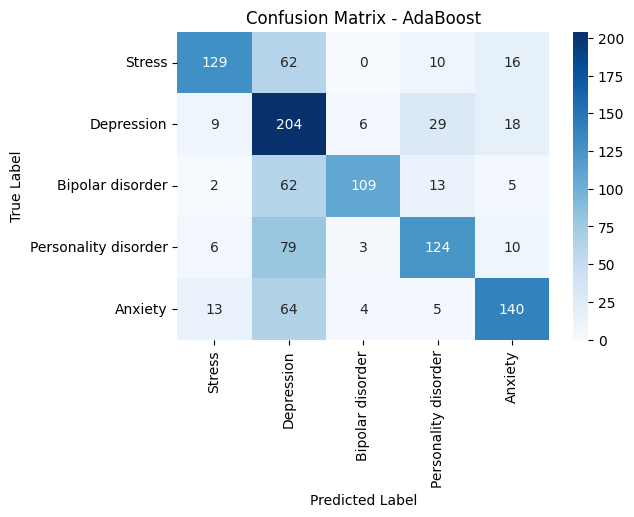

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_ada)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.title("Confusion Matrix - AdaBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Gradient Boosting

In [27]:
# Model 2: Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, random_state=42)

In [28]:
# Model Training
gb.fit(X_train_tfidf, y_train)

GradientBoostingClassifier(n_estimators=150, random_state=42)

In [29]:
# Model Testing
y_pred_gb = gb.predict(X_test_tfidf)

In [30]:
# Model Evaluation
print(" Gradient Boosting Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_gb, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_gb, average='weighted'))
print(classification_report(y_test, y_pred_gb))

 Gradient Boosting Evaluation
Accuracy: 0.7486631016042781
Precision: 0.760161155192956
Recall: 0.7486631016042781
F1 Score: 0.7513817250543128
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       217
           1       0.62      0.76      0.68       266
           2       0.84      0.77      0.81       191
           3       0.75      0.72      0.73       222
           4       0.79      0.76      0.77       226

    accuracy                           0.75      1122
   macro avg       0.77      0.75      0.76      1122
weighted avg       0.76      0.75      0.75      1122



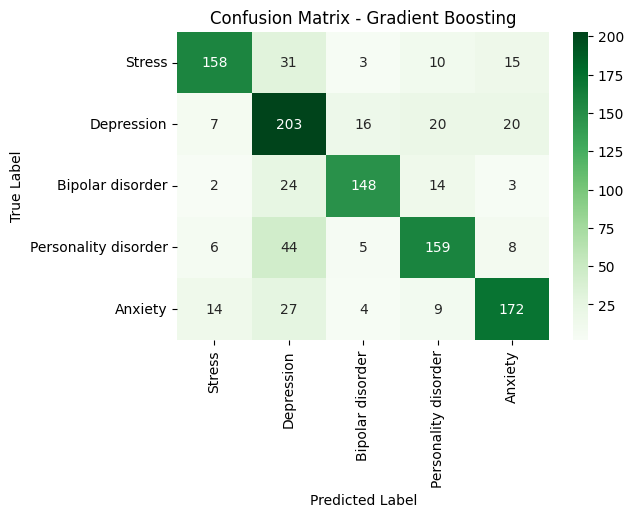

In [31]:
# Confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(6,4))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### XGBoost

In [32]:
# Model 3: XGBoost
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='logloss', random_state=42)

In [33]:
# Model Training
xgb.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [34]:
# Model Testing
y_pred_xgb = xgb.predict(X_test_tfidf)

In [35]:
# Model Evaluation
print(" XGBoost Evaluation ")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print(classification_report(y_test, y_pred_xgb))

 XGBoost Evaluation 
Accuracy: 0.7816399286987522
Precision: 0.7833470236118529
Recall: 0.7816399286987522
F1 Score: 0.7820591143645531
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       217
           1       0.70      0.75      0.72       266
           2       0.88      0.88      0.88       191
           3       0.73      0.73      0.73       222
           4       0.82      0.76      0.79       226

    accuracy                           0.78      1122
   macro avg       0.79      0.79      0.79      1122
weighted avg       0.78      0.78      0.78      1122



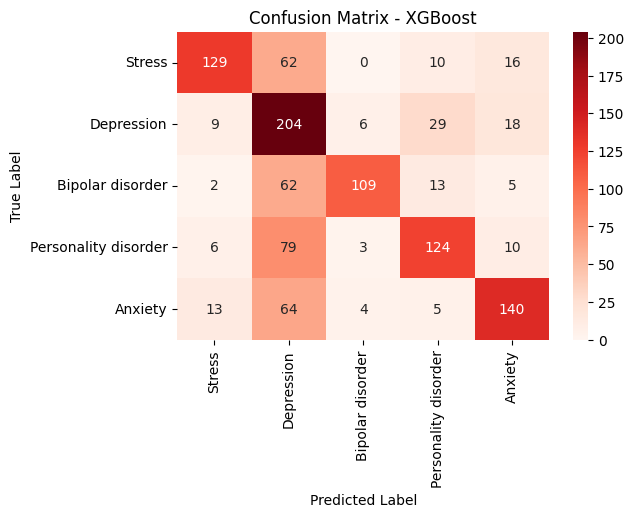

In [36]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Neural Network (MLP)

In [37]:
# Model 4: Neural Network (MLP)
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=10, random_state=42)

In [38]:
# Model Training
mlp.fit(X_train_tfidf, y_train)

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=10, random_state=42)

In [39]:
# Model Testing
y_pred_mlp = mlp.predict(X_test_tfidf)

In [40]:
# Model Evaluation
print(" MLP Neural Network Evaluation ")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Precision:", precision_score(y_test, y_pred_mlp, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_mlp, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_mlp, average='weighted'))
print(classification_report(y_test, y_pred_mlp))

 MLP Neural Network Evaluation 
Accuracy: 0.7557932263814616
Precision: 0.757318970088959
Recall: 0.7557932263814616
F1 Score: 0.7560512057799655
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       217
           1       0.72      0.76      0.74       266
           2       0.82      0.76      0.79       191
           3       0.75      0.74      0.74       222
           4       0.77      0.73      0.75       226

    accuracy                           0.76      1122
   macro avg       0.76      0.76      0.76      1122
weighted avg       0.76      0.76      0.76      1122



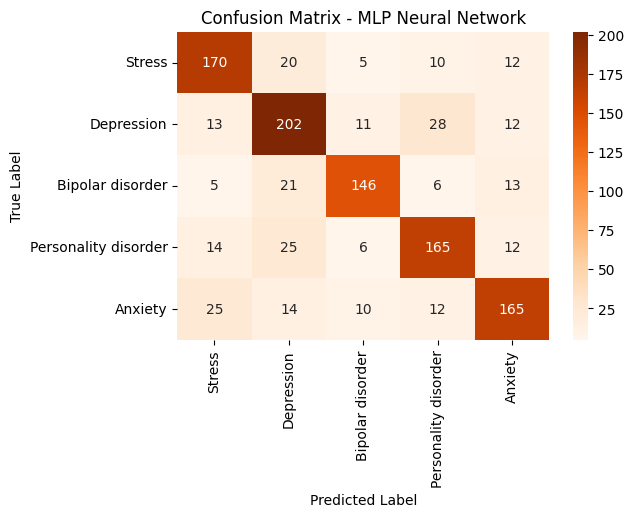

In [41]:
# COnfusion matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(6,4))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Oranges",
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.title("Confusion Matrix - MLP Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

* BERT Model

In [42]:
vocab_size = 10000   # same as tokenizer num_words
max_len = 100        # same as padding length

In [43]:
def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    # Multi-head Self-attention
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=ff_dim
    )(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])
    out1 = LayerNormalization()(attention_output)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    out2 = Add()([out1, ff_output])
    return LayerNormalization()(out2)

In [44]:
# BERT Model Definition
input_layer = Input(shape=(max_len,), dtype=tf.int32)
embedding_layer = Embedding(vocab_size, 128)(input_layer)

In [45]:
# Transformer layers similar to BERT-base conceptual architecture
x = transformer_encoder(embedding_layer, num_heads=4, ff_dim=128)
x = transformer_encoder(x, num_heads=4, ff_dim=128)

In [46]:
# Pooler
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(5, activation='softmax')(x)

bert_scratch_model = Model(inputs=input_layer, outputs=output)
bert_scratch_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [47]:
# Model Summary
bert_scratch_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    263,808 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 128)  │          0 │ embedding[0][0],  │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 128)  │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 100, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100, 128)  │     16,512 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 100, 128)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,891,845 (7.22 MB)

 Trainable params: 1,891,845 (7.22 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Train using padded sequences created earlier (X_train_pad & X_test_pad)
history_scratch = bert_scratch_model.fit(
    X_train_pad,
    y_train_pad,
    validation_data=(X_test_pad, y_test_pad),
    epochs=10,
    batch_size=32
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.2415 - loss: 1.6627 - val_accuracy: 0.3824 - val_loss: 1.5209
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3702 - loss: 1.4462 - val_accuracy: 0.6471 - val_loss: 0.9598
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6641 - loss: 0.9023 - val_accuracy: 0.6818 - val_loss: 0.8261
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7686 - loss: 0.6735 - val_accuracy: 0.7264 - val_loss: 0.7610
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8489 - loss: 0.4756 - val_accuracy: 0.7308 - val_loss: 0.8246
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8916 - loss: 0.3793 - val_accuracy: 0.7398 - val_loss: 0.8763
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9307 - loss: 0.2427 - val_accuracy: 0.7451 - val_loss: 0.9140
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9500 - loss: 0.1843 - val_acc

In [49]:
# Evaluate
pred_scratch = bert_scratch_model.predict(X_test_pad)
pred_labels_scratch = np.argmax(pred_scratch, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [50]:
print("Scratch-BERT Model Evaluation")
print("Accuracy:", accuracy_score(y_test_pad, pred_labels_scratch))
print("Precision:", precision_score(y_test_pad, pred_labels_scratch, average='weighted'))
print("Recall:", recall_score(y_test_pad, pred_labels_scratch, average='weighted'))
print("F1 Score:", f1_score(y_test_pad, pred_labels_scratch, average='weighted'))
print(classification_report(y_test_pad, pred_labels_scratch))


Scratch-BERT Model Evaluation
Accuracy: 0.7433155080213903
Precision: 0.7443303291670583
Recall: 0.7433155080213903
F1 Score: 0.7428217273567475
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       217
           1       0.73      0.66      0.69       266
           2       0.81      0.86      0.84       191
           3       0.67      0.74      0.71       222
           4       0.72      0.74      0.73       226

    accuracy                           0.74      1122
   macro avg       0.75      0.75      0.75      1122
weighted avg       0.74      0.74      0.74      1122



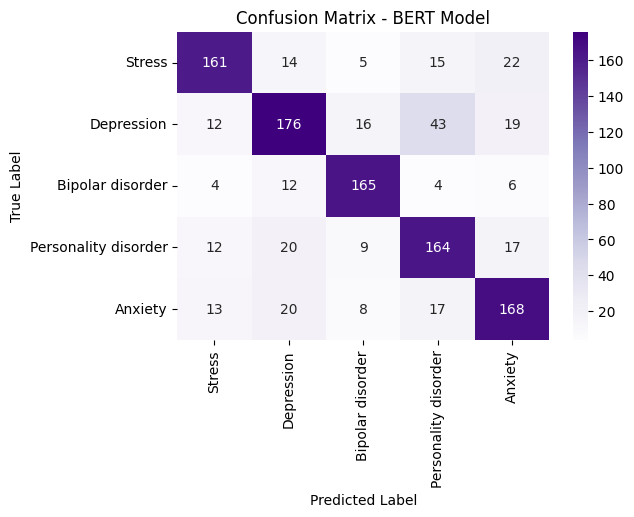

In [51]:
cm = confusion_matrix(y_test_pad, pred_labels_scratch)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.title("Confusion Matrix - BERT Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Model Comparision

In [52]:
# Create a DataFrame to store the evaluation metrics
metrics_data = {
    'Model': ['AdaBoost', 'Gradient Boosting', 'XGBoost', 'MLP', 'BERT'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_ada),
        accuracy_score(y_test, y_pred_gb),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_mlp),
        accuracy_score(y_test_pad, pred_labels_scratch)
    ],
    'Precision': [
        precision_score(y_test, y_pred_ada, average='weighted'),
        precision_score(y_test, y_pred_gb, average='weighted'),
        precision_score(y_test, y_pred_xgb, average='weighted'),
        precision_score(y_test, y_pred_mlp, average='weighted'),
        precision_score(y_test_pad, pred_labels_scratch, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_ada, average='weighted'),
        recall_score(y_test, y_pred_gb, average='weighted'),
        recall_score(y_test, y_pred_xgb, average='weighted'),
        recall_score(y_test, y_pred_mlp, average='weighted'),
        recall_score(y_test_pad, pred_labels_scratch, average='weighted')
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_ada, average='weighted'),
        f1_score(y_test, y_pred_gb, average='weighted'),
        f1_score(y_test, y_pred_xgb, average='weighted'),
        f1_score(y_test, y_pred_mlp, average='weighted'),
        f1_score(y_test_pad, pred_labels_scratch, average='weighted')
    ]
}

metrics_df = pd.DataFrame(metrics_data)

print("Model Evaluation Metrics:")
display(metrics_df)

Model Evaluation Metrics:


,Model,Accuracy,Precision,Recall,F1 Score
0,AdaBoost,0.629234,0.696444,0.629234,0.640180
1,Gradient Boosting,0.748663,0.760161,0.748663,0.751382
2,XGBoost,0.781640,0.783347,0.781640,0.782059
3,MLP,0.755793,0.757319,0.755793,0.756051
4,BERT,0.743316,0.744330,0.743316,0.742822


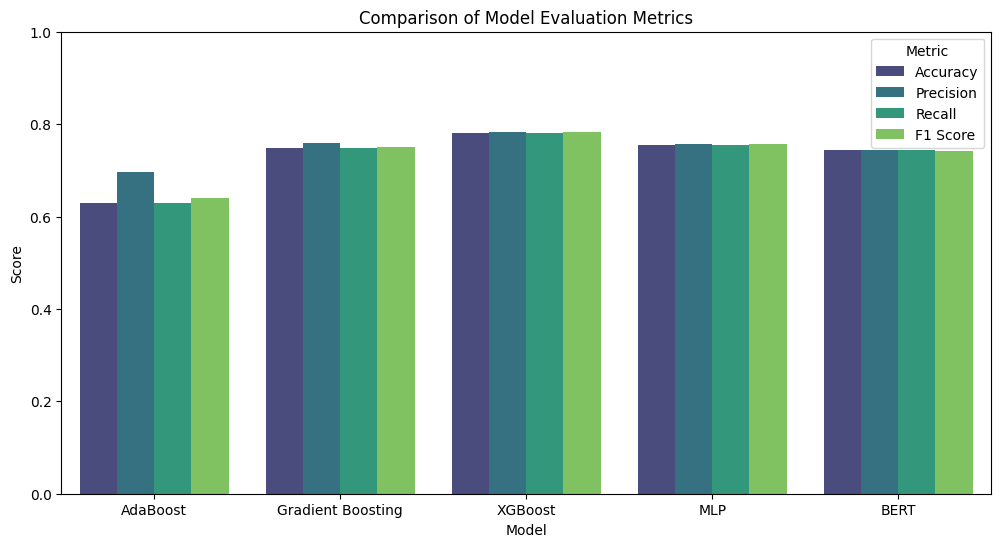

In [53]:
# Plot the evaluation metrics
metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df_melted, palette='viridis')
plt.title("Comparison of Model Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

### SHAP Interpretability

In [54]:
!pip install shap --quiet
!pip install lime --quiet
import shap
from lime.lime_text import LimeTextExplainer

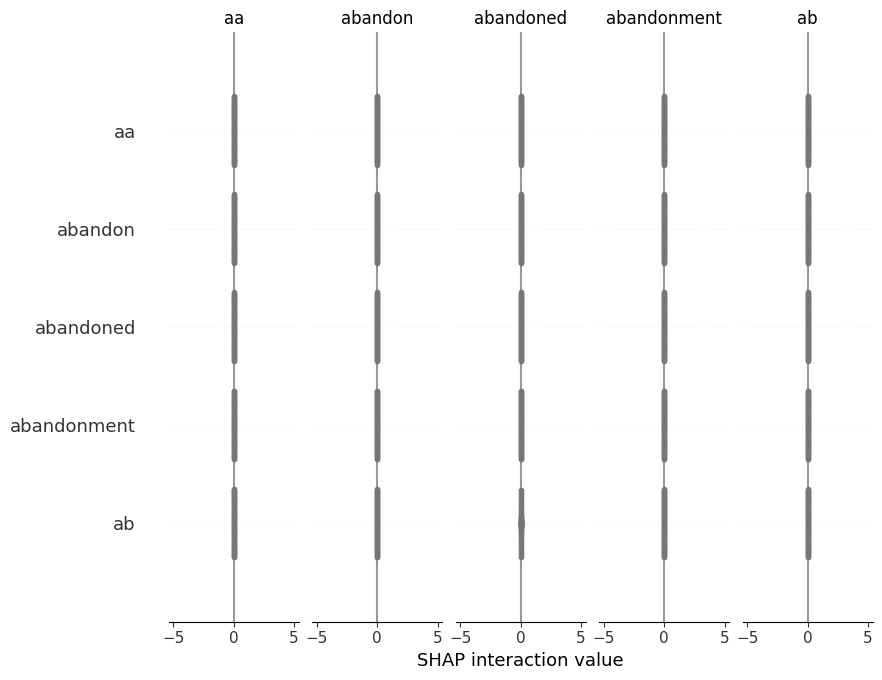

In [55]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb)

# Select sample data for explanation
sample_data = X_test_tfidf[:100]

# Compute SHAP values
shap_values = explainer.shap_values(sample_data)

# Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values, sample_data, feature_names=tfidf.get_feature_names_out())

### LIME Interpretability

In [56]:
# Label Mapping
class_names = ['Stress', 'Depression', 'Bipolar disorder', 'Personality disorder', 'Anxiety']

explainer = LimeTextExplainer(class_names=class_names)

# Define prediction function for LIME
def predict_proba(texts):
    text_tfidf = tfidf.transform(texts)
    return xgb.predict_proba(text_tfidf)

sample_text = df['clean_text'].iloc[10]

exp = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10,
    labels=(0, 1, 2, 3, 4)
)

# Display explanation
exp.show_in_notebook(text=True)

### McNemar’s Test

In [57]:
!pip install statsmodels --quiet
from statsmodels.stats.contingency_tables import mcnemar

# Compare XGBoost vs BERT Scratch
xgb_pred = y_pred_xgb
bert_pred = pred_labels_scratch

In [58]:
# Build contingency table
b00 = b01 = b10 = b11 = 0

for i in range(len(y_test)):
    correct_xgb = (xgb_pred[i] == y_test.values[i])
    correct_bert = (bert_pred[i] == y_test.values[i])

    if correct_xgb and correct_bert:
        b11 += 1
    elif correct_xgb and not correct_bert:
        b10 += 1
    elif not correct_xgb and correct_bert:
        b01 += 1
    else:
        b00 += 1

contingency_table = [[b11, b10],
                     [b01, b00]]

print("Contingency Table:")
print(np.array(contingency_table))

Contingency Table:
[[763 114]
 [ 71 174]]


In [59]:
# Perform McNemar test
result = mcnemar(contingency_table, exact=True)

print("\nMcNemar’s Test Result")
print("Statistic:", result.statistic)
print("p-value:", result.pvalue)


McNemar’s Test Result
Statistic: 71.0
p-value: 0.0019352292476659421


In [60]:
import joblib

# Save trained XGBoost model
joblib.dump(xgb, "mental_health_xgb_model.pkl")

# Save TF-IDF vectorizer for input processing
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']